In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
DATA_PATH = "weatherHistory.csv"
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [37]:
df = pd.read_csv(DATA_PATH)
print("Initial rows:", df.shape[0])
print("Columns:", df.columns.tolist())
print(df.head(3))

print("\nBasic info:")
print(df.info())

Initial rows: 96453
Columns: ['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary']
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.

In [ ]:
# Column selection
cols_needed = [
    'Formatted Date', 'Temperature (C)', 'Apparent Temperature (C)',
    'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
    'Visibility (km)', 'Pressure (millibars)',
    'Summary', 'Precip Type'
]

cols_available = [c for c in cols_needed if c in df.columns]
df = df[cols_available].copy()
print("\nSelected columns:", df.columns.tolist())


Selected columns: ['Formatted Date', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Summary', 'Precip Type']


In [ ]:
# Data Cleaning
before = df.shape[0]
df = df.drop_duplicates()
print(f"Removed duplicates: {before - df.shape[0]} rows")

if 'Formatted Date' in df.columns:
    # Handle timezone information and any invalid strings
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce', utc=True)
    df['Formatted Date'] = df['Formatted Date'].dt.tz_convert(None)  # remove timezone after parsing

    # Check for remaining invalids
    invalid_count = df['Formatted Date'].isna().sum()
    if invalid_count > 0:
        print(f"\n⚠️ Found {invalid_count} truly invalid date values:")
        print(df.loc[df['Formatted Date'].isna(), 'Formatted Date'].head(10))
        df = df.dropna(subset=['Formatted Date'])
    else:
        print("All dates parsed successfully with proper timezone handling.")

    # Extract datetime features
    df['year'] = df['Formatted Date'].dt.year
    df['month'] = df['Formatted Date'].dt.month
    df['day'] = df['Formatted Date'].dt.day
    df['hour'] = df['Formatted Date'].dt.hour
    df['dayofweek'] = df['Formatted Date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

print("\nDate feature extraction complete!")

Removed duplicates: 24 rows
✅ All dates parsed successfully with timezone handling.

Date feature extraction complete!


In [ ]:
# Check for empty values
# Fill or mark categorical NAs
if 'Precip Type' in df.columns:
    df['Precip Type'] = df['Precip Type'].fillna('none')
if 'Summary' in df.columns:
    df['Summary'] = df['Summary'].fillna('unknown')

# Drop rows with missing target
df = df.dropna(subset=['Temperature (C)']).reset_index(drop=True)
print("Rows after dropping missing target:", df.shape[0])


Rows after dropping missing target: 96429


In [ ]:
# Handling potetntial outliers using IQR method
def remove_outliers_iqr(data, col='Temperature (C)', k=1.5, verbose=True):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR

    if verbose:
        print(f"\nOutlier detection for '{col}':")
        print(f"Q1 = {Q1:.2f}, Q3 = {Q3:.2f}, IQR = {IQR:.2f}")
        print(f"Lower bound = {lower:.2f}, Upper bound = {upper:.2f}")

    # Count potential outliers 
    outliers = ((data[col] < lower) | (data[col] > upper)).sum()
    if verbose:
        print(f"Detected potential outliers: {outliers}")

    # Return cleaned data
    cleaned_data = data[(data[col] >= lower) & (data[col] <= upper)]
    return cleaned_data

REMOVE_OUTLIERS = True

if REMOVE_OUTLIERS:
    before = df.shape[0]
    df = remove_outliers_iqr(df, 'Temperature (C)')
    after = df.shape[0]
    print(f"Removed outliers: {before - after} rows")
else:
    print("Outlier removal skipped.")


Outlier detection for 'Temperature (C)':
Q1 = 4.71, Q3 = 18.84, IQR = 14.13
Lower bound = -16.48, Upper bound = 40.03
Detected potential outliers: 0
Removed outliers: 0 rows


In [ ]:
# Feature and target selection
target = 'Temperature (C)'

cols_to_exclude = ['Formatted Date', target, 'Apparent Temperature (C)']
feature_cols = [c for c in df.columns if c not in cols_to_exclude]
print("Features used:", feature_cols)

X = df[feature_cols].copy()
y = df[target].copy()

Features used: ['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Summary', 'Precip Type', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend']


In [ ]:
# Splitting train and test data from kaggle weather dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 77108 Test size: 19277


In [ ]:
# Preprocessing pipelines for both numeric and categorical data
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # use sparse_output=False for newer sklearn versions
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder='drop')

Numeric cols: ['Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend']
Categorical cols: ['Summary', 'Precip Type']


In [48]:
# ----------------------
# helper: evaluate function
# ----------------------
def evaluate_model(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"----- {name} Evaluation -----")
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R2:   {r2:.6f}\n")
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

----- Linear Regression Evaluation -----
MAE:  4.749143
RMSE: 5.819726
R2:   0.624727



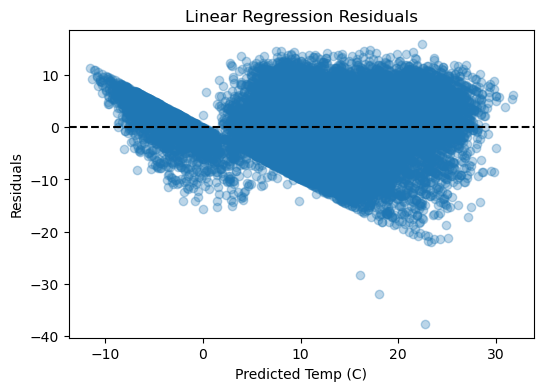

In [ ]:
# Linear Regression Model
lin_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lin_pipeline.fit(X_train, y_train)
y_pred_lin = lin_pipeline.predict(X_test)
res_lin = evaluate_model(y_test, y_pred_lin, "Linear Regression")

plt.figure(figsize=(6,4))
plt.scatter(y_pred_lin, y_test - y_pred_lin, alpha=0.3)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted Temp (C)")
plt.ylabel("Residuals")
plt.title("Linear Regression Residuals")
plt.show()


----- Random Forest (default) Evaluation -----
MAE:  1.190922
RMSE: 1.655478
R2:   0.969634



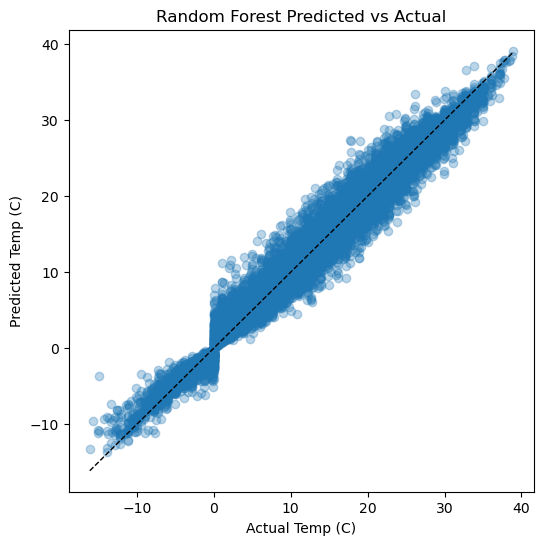

In [ ]:
# Random Forest Regressor Model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
res_rf = evaluate_model(y_test, y_pred_rf, "Random Forest (default)")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel("Actual Temp (C)")
plt.ylabel("Predicted Temp (C)")
plt.title("Random Forest Predicted vs Actual")
plt.show()


Top feature importances:
 Humidity                  0.363841
month                     0.316443
Precip Type_snow          0.190944
Pressure (millibars)      0.024917
day                       0.024195
year                      0.018044
hour                      0.015757
Wind Bearing (degrees)    0.013763
Wind Speed (km/h)         0.008621
Visibility (km)           0.006921
dayofweek                 0.005857
Precip Type_rain          0.005632
Summary_Mostly Cloudy     0.001111
Summary_Partly Cloudy     0.001019
Summary_Overcast          0.001005
dtype: float64


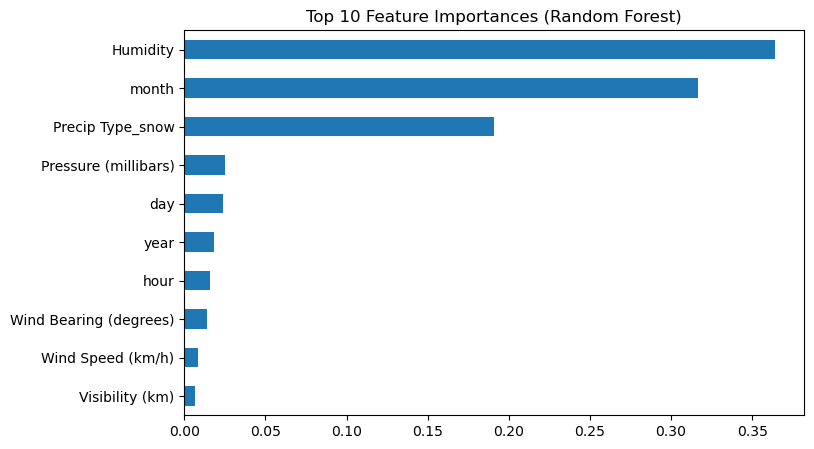

In [ ]:
# Feature Importance for Random Forest
# Extract feature names from preprocessing
preprocessor = rf_pipeline.named_steps['preprocessor']
regressor = rf_pipeline.named_steps['regressor']

# Numeric features
numeric_feature_names = numeric_cols

# Categorical features after one-hot encoding
cat_transformer = preprocessor.named_transformers_['cat']
if cat_transformer is not None and hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
    cat_feature_names = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_cols)
    cat_feature_names = list(cat_feature_names)
else:
    cat_feature_names = [f"cat_{i}" for i in range(len(categorical_cols))]

# Combining numeric and categorical features
final_feature_names = numeric_feature_names + cat_feature_names

# Get feature importances from Random Forest
importances = regressor.feature_importances_
fi = pd.Series(importances, index=final_feature_names).sort_values(ascending=False)

# Print top 15 features
print("Top feature importances:\n", fi.head(15))

# Plot top 10 feature importances
plt.figure(figsize=(8,5))
fi.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [ ]:
# Hyper Parameter Tuning using Grid Search for Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__max_features': [0.5, 0.7, 0.9, 'sqrt'],
    'regressor__min_samples_split': [2, 5]
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best params (RF grid):", grid.best_params_)
best_rf = grid.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
res_best_rf = evaluate_model(y_test, y_pred_best_rf, "Random Forest (tuned)")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params (RF grid): {'regressor__max_depth': None, 'regressor__max_features': 0.9, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
----- Random Forest (tuned) Evaluation -----
MAE:  1.195151
RMSE: 1.650040
R2:   0.969833



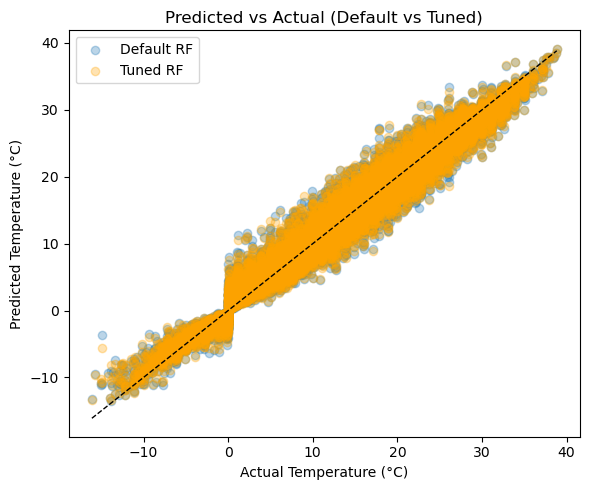


🔹 Model Comparison:
Default RF  -> MAE: 1.1909, RMSE: 1.6555, R2: 0.9696
Tuned RF    -> MAE: 1.1952, RMSE: 1.6500, R2: 0.9698


In [ ]:
# Model Comparison between Random Forest default vs tuned
plt.figure(figsize=(6, 5))

# Predicted Value Vs Actual
plt.scatter(y_test, y_pred_rf, alpha=0.3, label='Default RF')
plt.scatter(y_test, y_pred_best_rf, alpha=0.3, color='orange', label='Tuned RF')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Predicted vs Actual (Default vs Tuned)")
plt.legend()

plt.tight_layout()
plt.show()

# Comparison Summary 
print("\n🔹 Model Comparison:")
print(f"Default RF  -> MAE: {res_rf['mae']:.4f}, RMSE: {res_rf['rmse']:.4f}, R2: {res_rf['r2']:.4f}")
print(f"Tuned RF    -> MAE: {res_best_rf['mae']:.4f}, RMSE: {res_best_rf['rmse']:.4f}, R2: {res_best_rf['r2']:.4f}")

In [ ]:
# Gradient Boosting Test
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
res_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")


----- Gradient Boosting Evaluation -----
MAE:  2.401833
RMSE: 3.019272
R2:   0.898994



In [56]:
# Save the best model based on test R2
models_scores = {
    'linear': res_lin['r2'],
    'rf_tuned': res_best_rf['r2'],
    'gb': res_gb['r2']
}
best_name = max(models_scores, key=models_scores.get)
best_model = {'linear': lin_pipeline, 'rf_tuned': best_rf, 'gb': gb_pipeline}[best_name]
print(f"Best model by test R2: {best_name} (R2 = {models_scores[best_name]:.6f})")

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
print("Cross-validated R2 on training folds: mean {:.6f}, std {:.6f}".format(np.mean(cv_scores), np.std(cv_scores)))

MODEL_OUT = "best_weather_model.joblib"
joblib.dump(best_model, MODEL_OUT)
print("Saved best model to", MODEL_OUT)

Best model by test R2: rf_tuned (R2 = 0.969833)
Cross-validated R2 on training folds: mean 0.965480, std 0.000847
Saved best model to best_weather_model.joblib


In [57]:
# Summary of all results
print("\nSummary of results:")
print("Linear Regression:", res_lin)
print("Random Forest (default):", res_rf)
print("Random Forest (tuned):", res_best_rf)
print("Gradient Boosting:", res_gb)

# Final evaluation of best model on train and test
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)
print("\nTrain R2 (best model):", r2_score(y_train, y_train_pred_best))
print("Test R2  (best model):", r2_score(y_test, y_test_pred_best))


Summary of results:
Linear Regression: {'mae': 4.749142674625824, 'rmse': np.float64(5.819726462092246), 'r2': 0.6247267853960321}
Random Forest (default): {'mae': 1.1909223945634695, 'rmse': np.float64(1.6554779675668907), 'r2': 0.9696338849706732}
Random Forest (tuned): {'mae': 1.195151034912071, 'rmse': np.float64(1.6500403937038501), 'r2': 0.969833038114124}
Gradient Boosting: {'mae': 2.4018325245566263, 'rmse': np.float64(3.0192719224293763), 'r2': 0.8989940682780925}

Train R2 (best model): 0.995837518827515
Test R2  (best model): 0.969833038114124
